## Grad-CAM 

Integrated gradients offer a good way to pinpoint how individual pixels contribute to a model's decision. However, sometimes we need a broader view, and that is where Gradient-weighted Class Activation Mapping (Grad-CAM) shines. Grad-CAM provides a visual representation of the high-level regions in an image that has the most significant impact on a model's classification.

Let us imagine, you have a complex convolutional neural network (CNN) designed for image classification. Recall that CNNs process images through a series of layers. Early layers detect fundamental features like edges and textures, while later layers piece these together to recognize more complex concepts relevant to the task (think ‘cat' features). Grad-CAM cleverly focuses on these later layers to reveal what the network considers important for its predictions.

The process begins with a normal forward pass: our cat photo journeys through the network, activating neurons as it goes. The final layer spits out probabilities for each possible class, hopefully, a high score for ‘cat'! Now, we zero in on the single neuron in the final layer specifically associated with the ‘cat' label. This neuron encodes what features the network has learned to equate with ‘cat'.

Here is where gradients come in. We calculate how much a tiny change in the activation of neurons in the layer just before the final one would affect the ‘cat' score. These gradients are like little nudges, revealing which neurons in that earlier layer played the biggest role in driving the ‘cat' prediction. But Grad-CAM does not stop there. It combines this gradient information with feature maps present in the chosen convolutional layer. Each feature map highlights where the network detected specific patterns in the image. By carefully averaging the gradients with the values in these feature maps, Grad-CAM focusses on the features that most strongly reinforce the ‘cat' classification.

Finally, it is visualization time! Grad-CAM takes these combined signals and upscales them to the size of the original image. This creates a class activation map – a heatmap of sorts. This heatmap, overlaid on the original cat picture, visually pinpoints the broad regions (like the cat's face, ears, etc.) that were most crucial in convincing the model of its ‘cat' decision.

While integrated gradients provide a pixel-by-pixel breakdown of a model's decision, Grad-CAM offers a different kind of insight. It focuses on the big picture, revealing which large-scale features in an image hold the most influence on the model's classification. This broader perspective acts as a valuable check, helping us verify if the model is basing its decisions on the correct elements within the image.

Grad-CAM allows us to ask critical questions: Is the model zeroing in on the right things, or is it being misled by distractions in the background? By highlighting which image regions are driving the classification, Grad-CAM exposes potential flaws and biases in the model's logic. This is crucial, as even a seemingly accurate model might be arriving at its decisions for the wrong reasons. For example, when designing a model to detect cigarette butts on the street, you might discover that it sometimes focuses on surrounding rubble. Grad-CAM was instrumental in revealing this flaw. The visual explanation it provided helped me understand the issue, and ultimately, helped me to improve my model's accuracy.

In [1]:
import os
import numpy as np
import tensorflow
import skimage as ski
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import concurrent.futures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D, Dropout
from keras.optimizers import Adam
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from math import ceil
from time import time
import xplique
from xplique.attributions import IntegratedGradients
from xplique.plots import plot_attributions

In [2]:
# Folder paths where the images of each class are stored
folder_paths = ['cats_and_dogs/cats','cats_and_dogs/dogs']

# Class labels for the images (same order as folder_paths)
class_names = ["cats", 'dogs']

# Target size to resize the images
target_size = (224, 224)

# Arrays to store the images (X) and class labels (y)
X = []
y = []

for i in range(len(folder_paths)):
    for filename in os.listdir(folder_paths[i]):
        file_extension = os.path.splitext(filename)[1]
        # Check if the file extension is an image extension 
        if file_extension == ".jpg" or file_extension == ".jpeg" or file_extension == ".png": 
            image_filename = os.path.join(folder_paths[i], filename)
            # Read the image file using scikit-image
            image = ski.io.imread(image_filename)
            # Normalize the image to values between 0 and 1
            image = image / 255.0
            # Resize the image to the target_size
            image_resized = ski.transform.resize(image, target_size)            
            # Insert the image into array X
            X.append(image_resized)
            # Insert the class label into array y
            y.append(class_names[i])
            
# Convert of arrays into numpy arrays
X = np.array(X)
y = np.array(y)

In [3]:
data_gen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             zoom_range=0.2)

def GenerateImages(generator, image, num_images):
    new_images = []
    # we need to reshape the image because the generator.flow() 
    # expects an array of images
    image = np.reshape(image, (1,) + image.shape)
    for _ in range(num_images):
        batch = next(generator.flow(image, batch_size=1))
        new_images.append(batch[0])
    return np.array(new_images)

# Save the images to a new dataset 'X_augmented' and 'y_augmented'
X_augmented = []
y_augmented = []
for index in range(len(X)):
    images = GenerateImages(data_gen, X[index], 6)
    for i in range(6):
        X_augmented.append(images[i])
        y_augmented.append(y[index])  

# Convert lists to numpy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Encode the class labels into integers
label_encoder = LabelEncoder()
y_integer_encoded = label_encoder.fit_transform(y_augmented)  
num_classes = len(np.unique(y_integer_encoded))
y_onehot_encoded = keras.utils.to_categorical(y_integer_encoded, num_classes=num_classes)

In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented,
                                                    y_onehot_encoded,
                                                    test_size=1/10,
                                                    random_state=0)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 1/10,
                                                  random_state = 0)

In [5]:
# Create a sequential model
model = Sequential()

# Add convolutional layers, max pooling, and dropout layers
model.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=target_size + (3,), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(10, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64))

# Output layer
model.add(Dense(2, activation='softmax'))

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to monitor val_accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', 
                       patience=3)

# Train the model 
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=monitor_val_acc)

Epoch 1/100


2024-04-24 23:52:48.278489: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


456/456 [==============================] - 73s 159ms/step - loss: 0.6711 - accuracy: 0.5928 - val_loss: 0.6103 - val_accuracy: 0.6531
Epoch 2/100
456/456 [==============================] - 80s 174ms/step - loss: 0.5925 - accuracy: 0.6833 - val_loss: 0.6510 - val_accuracy: 0.6105
Epoch 3/100
456/456 [==============================] - 82s 179ms/step - loss: 0.5173 - accuracy: 0.7422 - val_loss: 0.5992 - val_accuracy: 0.6975
Epoch 4/100
456/456 [==============================] - 83s 183ms/step - loss: 0.4164 - accuracy: 0.8048 - val_loss: 0.6397 - val_accuracy: 0.6926
Epoch 5/100
456/456 [==============================] - 83s 182ms/step - loss: 0.2829 - accuracy: 0.8798 - val_loss: 0.9142 - val_accuracy: 0.6685
Epoch 6/100
456/456 [==============================] - 86s 188ms/step - loss: 0.1668 - accuracy: 0.9331 - val_loss: 1.0757 - val_accuracy: 0.6914


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 10)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 10)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 30250)             0         
                                                                 
 dense (Dense)               (None, 128)               3

__Step 1__: Setup

In [11]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

__Step 2:__ Configurable parameters

In [14]:
img_size = (224, 224)

last_conv_layer_name = "conv2d_1"

# The local path to our target image
img_path = ("cats_and_dogs/cats/cat.8.jpg")

__Step 3:__ The Grad-CAM algorithm

In [15]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

__Step 4:__ Let's test-drive it

1/1 [==============================] - 0s 76ms/step


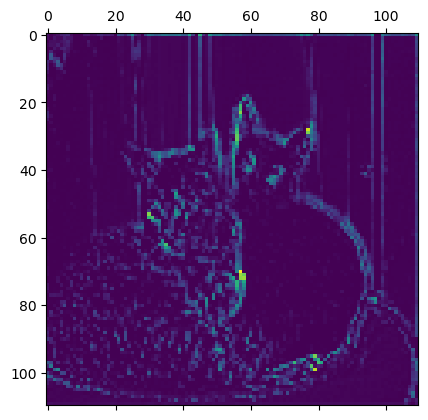

In [17]:
# Prepare image
img_array = get_img_array(img_path, size=img_size)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

## Second explanation

### __The method__

### **Attribution methods**

The main objective in attributions techniques is to highlight the discriminating variables for decision-making. For instance, with Computer Vision (CV) tasks, the main goal is to underline the pixels contributing the most in the input image(s) leading to the model’s output(s).



### **Back-propagation attribution methods**

Back-propagation methods are one of the two groups of attribution methods with perturbation based methods. Those methods use the weights of the model to back-propagate the importance from the prediction (class activation or regression) to the inputs. It was first introduced in 2013, with the saliency method from <a href="https://arxiv.org/abs/1312.6034">Simonyan et al</a>.  Back-propagation methods can be seen as white-box methods as they need the weights of the model.

### **CAM**

Class Activation Map (CAM) (<a href="https://arxiv.org/abs/1512.04150">Zhou et al. 2015</a>) was the main inspiration for Grad-CAM as Grad-CAM generalize CAM and Grad-CAM++ further extend it.

CAM can be applied to networks like VGG where there are block of convolutionnal layers before a dense layer and the output. The method computes attributions on the last convolutionnal layer, a value is given to each of its spatial coordinates. It uses the fact that convolutionnal layers and thus convolutionnal features mapping conserves a notion of spaciality between the input and the output. As such, after obtaining attributions for the last convolutionnal layer, they upsample the attributions to match the size of the input and obtain features attributions.

Before jumping to the formula, we need to introduce the Global Average Pooling (GAP) function. It basically sums an output on the spatial dimensions, living one value for each channel.

*(In this method and the two following, approximately all elements depends on the input $x$, thus it will be remove from the notations to increase readability.)*

Let's call the feature activation of the last convolutionnal layer $A$, such that $A_{ij}^k$ corresponds to the $(i,j)$ value on channel $k$.

$$GAP(A^k) = \sum_i \sum_j A_{ij}^k$$

Now, on the computation of the convolutionnal layer attributions can be defined through the following formula, where $CAM_c$ are the convolutionnal attributions for input $x$ and class $c$. The GAP are weighted by $w_c^k$ the weight between the channel $k$ and the output corresponding to class $c$.

$$ CAM_c = \sum_k w_c^k GAP(A^k) $$

Therefore, explanation function $\phi_c$ of a class $c$, can be defined by:

$$\phi_c(x) = upsample_{size(x)}(CAM_c) $$

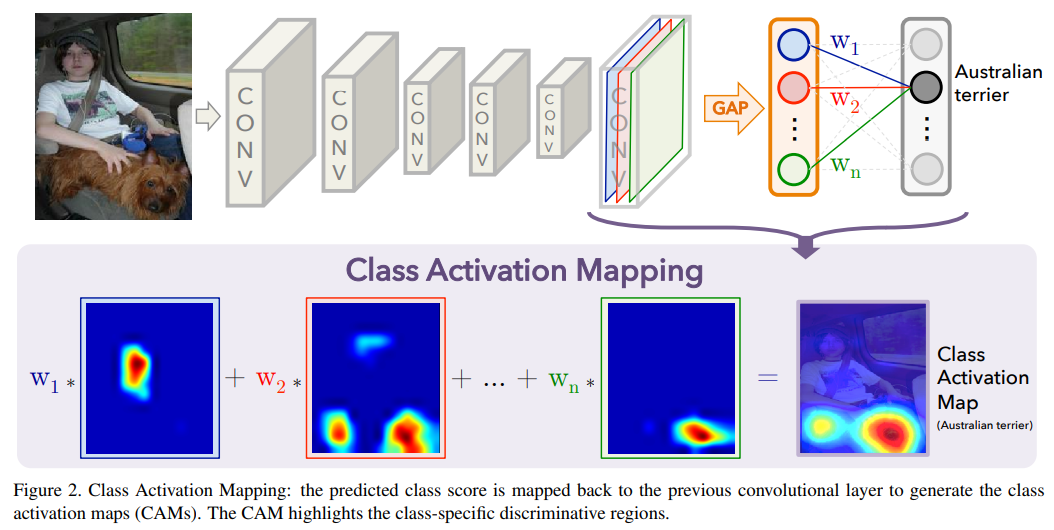

### **Grad-CAM**

<a href="https://arxiv.org/abs/1610.02391">Ramprasaath et al.</a> described Grad-CAM as "*Grad-CAM uses the gradient information flowing into the
last convolutional layer of the CNN to assign importance
values to each neuron for a particular decision of interest.*"

The method is really close to CAM, they also assign attribution to the last convolutionnal layer and upsample them to the input size. They also use the GAP function. Nevertheless, their design allow the use of the method on each convolutionnal layer and the last layer do not need to necessarly be a dense layer.

The difference with the CAM method is there use of the gradient computed via back-propagation $g_{ij}^{kc} = \frac{\delta S_c}{\delta A_{ij}^k}$. Where $S_c$ the unormalized score (layer before softmax) for class $c$ and $A_{ij}^k$ the activation of the studied convolutionnal layer output at channel $k$ and coodinates $(i,j)$.

They define the coefficient $\alpha_k^c$ by taking the GAP of this gradient. Z represent the number of elements in a channel of the studied convolutionnal layer.

$$\alpha_c^k = \frac{1}{Z} \sum_i \sum_j g_{ij}^{kc}$$

Now, on the computation of the convolutionnal layer attributions can be defined through the following formula, where $GradCAM_c$ are the convolutionnal attributions for class $c$. The GAP are weighted by $A^k$ the activations of channel $k$. $ReLU$ is the rectified linear unit function.

$$ GradCAM_c = ReLU(\sum_k \alpha_c^k A^k)$$

Therefore, explanation function $\phi_c$ of a class $c$, can be defined by:

$$\phi_c(x) = upsample_{size(x)}(GradCAM_c) $$

### **Grad-CAM++**

In their paper, <a href="https://arxiv.org/abs/1710.11063">Chattopadhyay, Sarkar et al.</a> argue that Grad-CAM is biased toward bigger object in the image. Therefore, they propose Grad-CAM++ to solve this problem.

The two final step are similar, the difference is in their definition of $\alpha_k^c$. They take the $ReLU$ value of the gradient and introduce a coefficient $\alpha_{ij}^{kc}$ to remove the aforementioned bias.

$$\alpha_c^k = \frac{1}{Z} \sum_i \sum_j \alpha_{ij}^{kc} ReLU(g_{ij}^{kc})$$

They define $\alpha_{ij}^{kc}$ as:

$$\alpha_{ij}^{kc} = \frac{(g_{ij}^{kc})^2}{2(g_{ij}^{kc})^2 + \sum_a \sum_b A_{ab}^k (g_{ij}^{kc})^3}$$


### Parameters overview

As most methods of the Xplique library, an explanation method have a few number of attributes (and their default values) useful to increase your explanation quality.

```python
explainer = GradCAM(model,
                    output_layer: Union[str, int] = None,
                    batch_size: int = 32,
                    conv_layer: Union[str, int] = None)
```

- The `output_layer` parameter is the index or name of the output layer corresponding to the label layer. The last layer layers can be activated (linear, softmax ...). The value of `output_layer` has no impact on the simulation time.

- The `batch_size` define the number of inputs to treat simultaneously.

- The `conv_layer` parameter is the index or name of the convolutionnal layer on which the algorithm is applied. The value of `conv_layer` has no impact on the simulation time.

The choice of the `conv_layer` and the `output_layer` have a great deal towards our explainer performance. The `conv_layer` layer has to be before the `output_layer` layer in the neural network system.

The detail on each attribute influence will be provided in the [Parameters influence](#influence) section.

### Parameter tuning tips

- The `output_layer` represents the index or name of the layer from which begin the back-propagation. It should be left to None, i.e the last layer of the model or the class activation layer.
- The `batch_size` represents the number of perturbed images treated simultaneously. It has an impact on the memory usage. You may use the batch size from your model training.
- The `conv_layer` parameter represents the index or the name of the convolutionnal layer the algorithm is applied on. It should be left to `None` to select the last convolutionnal layer in most cases.

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from math import ceil
from time import time

import xplique
from xplique.attributions import GradCAM, GradCAMPP
from xplique.plots import plot_attributions

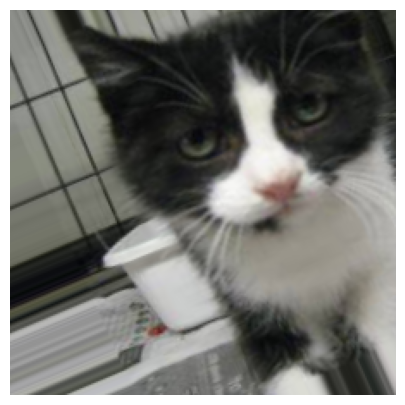

In [30]:
x = np.expand_dims(X_test[287], axis=0)  # Expand dimension for image
y = np.expand_dims(tf.keras.utils.to_categorical(1, 2), axis=0)

plt.rcParams["figure.figsize"] = [12.5, 5]
plt.imshow(x[0])
plt.axis('off')
plt.show()

### Methods simple utilization

This a minimal example on how to apply the SmoothGrad, SquareGrad and VarGrad methods. This focus on the right specification of the methods parameters. For further details and explanations on the attribution explainers API, please refer to the [Feature attribution tutorial](https://colab.research.google.com/drive/1XproaVxXjO9nrBSyyy7BuKJ1vy21iHs2)

GradCAM


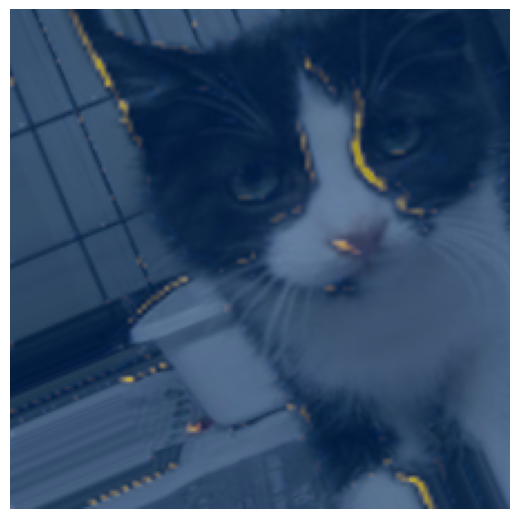

GradCAMPP


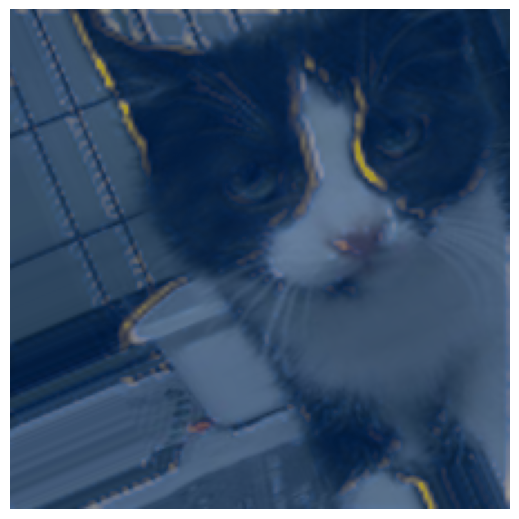

In [31]:
# define arbitrary parameters (common for all methods)
parameters = {
    "model": model,
    "output_layer": -1,
    "batch_size": 16,
    "conv_layer": None,
}

# instanciate one explainer for each method
explainers = {
    "GradCAM": GradCAM(**parameters),
    "GradCAMPP": GradCAMPP(**parameters),
}

# iterate on all methods
for method_name, explainer in explainers.items():
    # compute explanation by calling the explainer
    explanation = explainer.explain(x, y)

    # visualize explanation with plot_explanation() function
    print(method_name)
    plot_attributions(explanation, x, img_size=5, cmap='cividis', cols=1, alpha=0.6)
    plt.show()

The GradCAM and GradCAMPP methods need some knowledge to set their parameters right. Therefore we propose to summarize those informations in [the parameters tuning tips part](#tips). The parameters are described and explained in the following sections.

### Parameters influence

This section will present the influence of each parameter, it will be accompanied by visualization to illustrate it. Each parameter will be described one by one.

The two presented methods are grouped together because they have the same parameters and those parameters have similar influences. Therefore we will import one of the two methods as "Method" and make the analysis with it. However, you can change the studied method by commenting and uncommenting the corresponding lines.

### **output_layer**

The `output_layer` parameter is an integer indexing the layer from which begin the back-propagations or a string with the name of this layer. The different papers consider the last layer of the neural neural which is the class activation layer. (The methods can also be applied to regression methods, please see the corresponding tutorial from the <a href="https://deel-ai.github.io/xplique/tutorials/"> list of Xplique tutorials</a>).

To come back to the `output_layer` parameter, we suggest not to change it as the resulting attributions would not be easily interpretable and may be misleading.

### **batch_size**

The `batch_size` parameter should be a positive integer, it indicates the number of perturbed images treated simultaneously.
- Too small values will increase the execution time.
- Too huge values may lead to out of memory errors.
This parameter should be set taking into account your hardware and the image size. The most simple solution is to used the same batch size you use during the training of your model.

### **conv_layer**

The `conv_layer` parameter corresponds to the index or name of the convolutionnal layer the attributions are computed on.

There may be a huge number of convolutionnal layers in your model, for most of them, the explanation will not make sense. Furthermore, there is a low chance that the explanation will be more pertinent than the one obtained by default on the last convolutionnal layer.

Therefore, in most cases, the `conv_layer` parameter should be left to `None`.

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 10)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 10)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 30250)             0         
                                                                 
 dense (Dense)               (None, 128)               3

conv_layer: conv2d -> 0.0602s


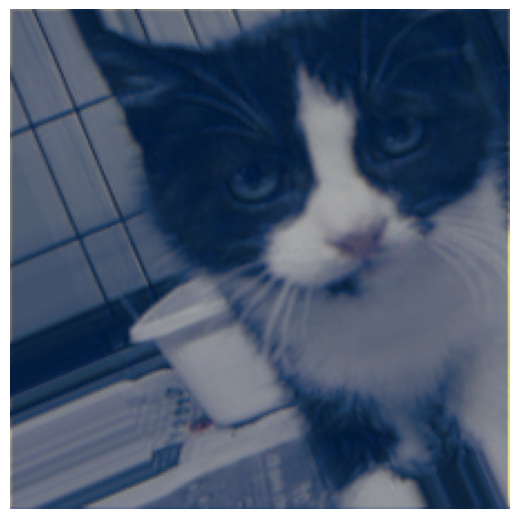

conv_layer: conv2d_1 -> 0.0708s


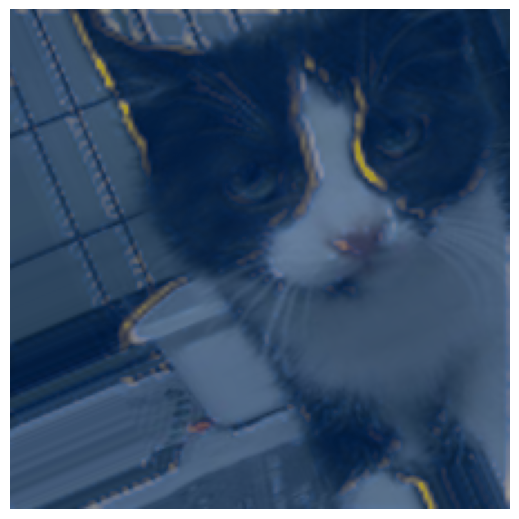

In [32]:
# Method = GradCAM
Method = GradCAMPP

batch_size = 16
# None will select "conv2d_93" (cf architecture)
# Most other values will make warnings or errors
conv_layers = ["conv2d", "conv2d_1"]

for conv_layer in conv_layers:
    t = time()
    explainer = Method(model,
                       batch_size=batch_size,
                       conv_layer=conv_layer)

    explanation = explainer.explain(x, y)
    print(f"conv_layer: {conv_layer} -> {round(time()-t, 4)}s")

    plot_attributions(explanation, x, img_size=5, cmap='cividis', alpha=0.6)
    plt.show()